## Multi-Model Neural Network Approach

Using KeyBert, OpenAI, or doc2vec Embeddings

Architecture: simple with 1 ReLu hidden layer

Train test split: 75/25

Single-Classification Accuracy: 92.4%

Multi-Classification Accuracy: 92.0%


In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval

# pick which dataset to read

finished_df = pd.read_csv('finished_dataset/openai_finished_df.csv')
# finished_df = pd.read_csv('finished_dataset/keyBert_finished_df.csv')
# finished_df = pd.read_csv('finished_dataset/doc2vec_finished_df.csv')

finished_df['label'] = finished_df['label'].apply(literal_eval)
finished_df['similarity_readme'] = finished_df['similarity_readme'].apply(literal_eval)
finished_df['embedding_readme'] = finished_df['embedding_readme'].apply(literal_eval)
finished_df['embedding_description'] = finished_df['embedding_description'].apply(literal_eval)
finished_df['similarity_description'] = finished_df['similarity_description'].apply(literal_eval)
finished_df['embedding_topic'] = finished_df['embedding_topic'].apply(literal_eval)
finished_df['similarity_topic'] = finished_df['similarity_topic'].apply(literal_eval)

finished_df['features'] = finished_df.apply(lambda row: np.concatenate((
    row['embedding_readme'],
    row['embedding_description'], 
    row['embedding_topic'],
)), axis=1)

# label only contains 1 correct answer
finished_df.drop(finished_df[finished_df['label'].map(sum) != 1].index, inplace=True)

X = np.stack(finished_df['features'].values)
y = np.stack(finished_df['label'].values)

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (825, 4608)
X_test shape: (275, 4608)
y_train shape: (825, 20)
y_test shape: (275, 20)


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers.legacy import Adam # legacy faster on m2 macs
from tensorflow.keras.regularizers import l1_l2

model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_split=0.3, callbacks=[early_stopping], verbose=0)

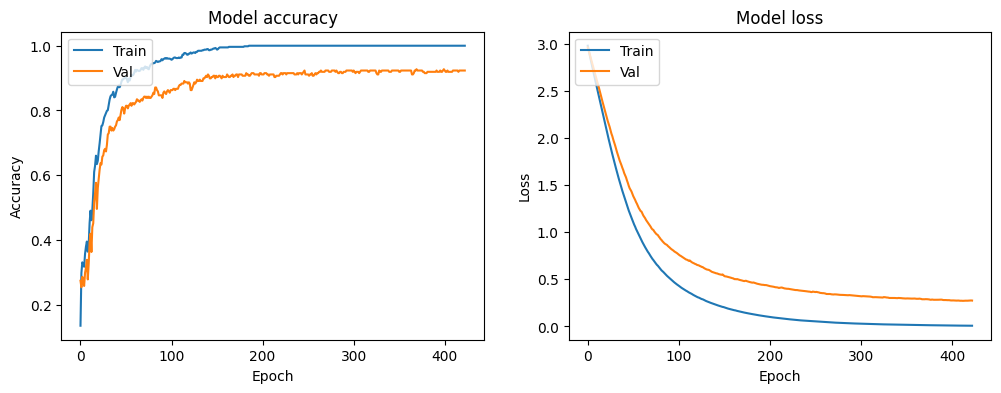

26/26 [==============================] - 0s 597us/step - loss: 0.0876 - accuracy: 0.9770
Train accuracy: 0.9769697189331055
9/9 [==============================] - 0s 674us/step - loss: 0.2971 - accuracy: 0.9055
Val accuracy: 0.9054545164108276


In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()

print(f'Train accuracy: {model.evaluate(X_train, y_train)[1]}')
print(f'Val accuracy: {model.evaluate(X_test, y_test)[1]}')

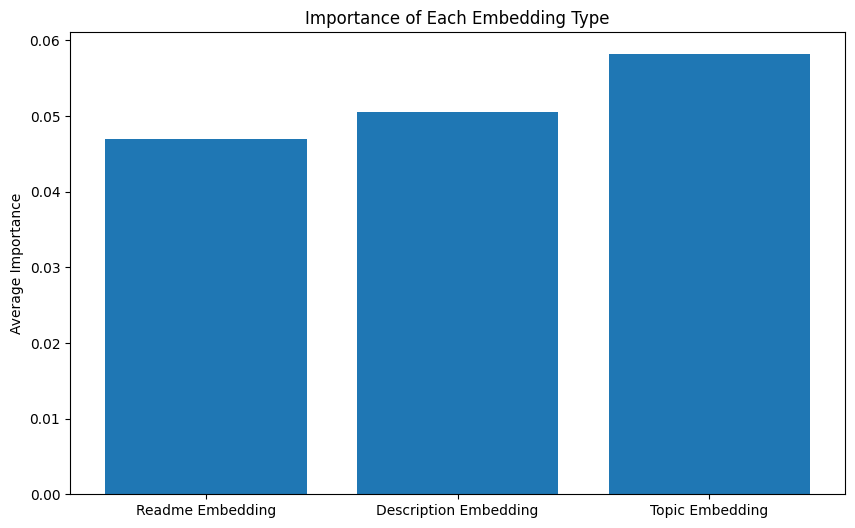

In [20]:
# Extract weights of the first dense layer
weights = model.layers[0].get_weights()[0]

# Determine the size of each embedding
embedding_size = weights.shape[0] // 3

# Calculate importance for each embedding type
importance_readme = np.mean(np.abs(weights[:embedding_size]), axis=1)
importance_description = np.mean(np.abs(weights[embedding_size:2*embedding_size]), axis=1)
importance_topic = np.mean(np.abs(weights[2*embedding_size:]), axis=1)

# Average the importances across all output nodes to get a single score per embedding type
avg_importance_readme = np.mean(importance_readme)
avg_importance_description = np.mean(importance_description)
avg_importance_topic = np.mean(importance_topic)

# Create a bar plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
bar_positions = np.arange(3)
bar_heights = [avg_importance_readme, avg_importance_description, avg_importance_topic]
bar_labels = ['Readme Embedding', 'Description Embedding', 'Topic Embedding']

plt.bar(bar_positions, bar_heights, align='center')
plt.xticks(bar_positions, bar_labels)
plt.ylabel('Average Importance')
plt.title('Importance of Each Embedding Type')
plt.show()


In [11]:
# santiy check

import numpy as np

y_pred = model.predict(X_test)

correct = 0

for i in range(len(y_pred)):
    # print(f'Actual: {np.argmax(y_test[i])} | Predicted: {np.argmax(y_pred[i])}')
    if np.argmax(y_test[i]) == np.argmax(y_pred[i]):
        correct += 1

print(f'Accuracy: {correct/len(y_pred)}')

11/11 [==============================] - 0s 673us/step
Accuracy: 0.7391304347826086


In [13]:
# attmept at Linear Regression

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

regression_models = []

for i in range(y_train.shape[1]):
    model = Sequential()
    model.add(Dense(1, input_dim=X_train.shape[1], activation='sigmoid'))  # Sigmoid for probability
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

    history = model.fit(X_train, y_train[:, i], epochs=100, batch_size=32, verbose=0)
    regression_models.append(model)
    
def predict_classes(models, X):
    X = np.array(X).reshape(1, -1)
    predictions = [model.predict(X, verbose = False).flatten() for model in models]
    return np.stack(predictions, axis=1)

In [14]:
import numpy as np

def predict_classes(models, X):
    predictions = [model.predict(X, verbose=False) for model in models]
    return np.stack(predictions, axis=-1).squeeze()

predicted_classes = predict_classes(regression_models, X_test).argmax(axis=-1)
actual_classes = y_test.argmax(axis=-1)

accuracy = np.mean(predicted_classes == actual_classes)
print(f'Accuracy: {accuracy}')


Accuracy: 0.7877906976744186
